# Convolutions and filtering

## BIOS 26211 winter 2023

## Keegan Ballantyne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener, gaussian, deconvolve, convolve
import pandas as pd
from scipy.fftpack import fft, ifft

## Part 1: Implementation of convolution in 1D

In this part you will implement the convolution function as a naive implementation and then check to see if the convolution theorem works. First, some definitions:

A *convolution* between a signal s(t) and a response (or kernel) r(t) is defined to be the following (for the case of discrete vectors s and r)

$$
 c[j] = s \circ r = \sum_i s[i] r[i-j] 
$$


The result of the convolution operation is a combination of the two functions that can be interpreted as a distorted or modified signal recorded by an instrument. One can also think of a kernel being used in a convolution to filter out or highlight certain features.

Here are a few simple examples of convolutions with a generated data set:

(1049,)
(1000,)


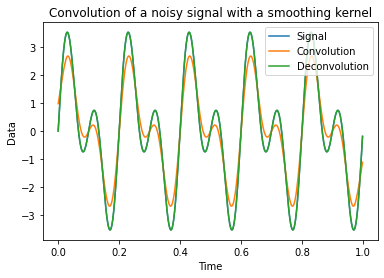

In [2]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t = np.arange(0,Max_time,Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
w3 = 0 # weight of random noise
signal = w1*np.sin(2*np.pi*ff1*t)+ w2*np.sin(2*np.pi*ff2*t) # add two sine waves

# smoothing kernel: a box function
n = 50 # length of the smoothing kernel
kernel = np.ones(n)/n # array of ones normalized

# convolution with same length option
conv_plot = np.convolve(signal, kernel, 'same')

conv = convolve(kernel, signal)

print(conv.shape)
deconv, remain = deconvolve(conv, kernel)

print(deconv.shape)

# plot the original signal and the convolution
plt.plot(t, signal, label = 'Signal')
plt.plot(t, conv_plot, label = 'Convolution')
plt.plot(t, deconv, label = 'Deconvolution')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Convolution of a noisy signal with a smoothing kernel')
plt.show()

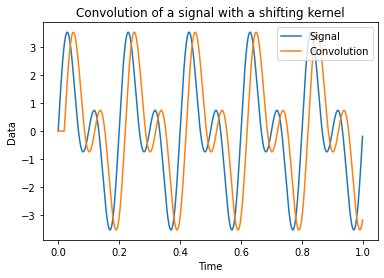

In [3]:
# shifting kernel: an impulse function
kernel = np.zeros(int(len(signal)/4))
kernel = np.zeros(len(signal))

kernel[20] = 1
# convolution with same length option
conv = np.convolve(signal, kernel, 'same') 

conv = convolve(signal, kernel)

# plot the original signal and the convolution
plt.plot(t, signal, label = 'Signal')
plt.plot(t, conv[:len(signal)], label = 'Convolution')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Convolution of a signal with a shifting kernel')
plt.show()

### 1.1 Direct convolution function

Implement your own version of the convolution for two one-dimensional arrays. This video gives a very clear explanation of the nuts and bolts of the calculation: https://www.youtube.com/watch?v=W56uw9GUvxU

Outline of algorithm:

* Input: two 1-dimensional arrays X and Y
* DO:
    + check that both X and Y are 1-dimensional arrays, if no return error message
    + if yes, then pad both arrays with zeros *at the beginning* so they are the same length (what should it be)? Hint: use the function `np.pad()`
    + initialize the array Z the fuction will return
    + start for loop for the length of padded arrays X and Y
        + calculate $Z[i]= \sum_j X[j]*Y[i-j]$ over all j 
        (you can use an internal loop or use numpy functions `np.flip` and `np.roll` to avoid another loop)
    + return the convolution array Z

Use the two arrays given below (used in the example from the video) to test your function. Compare the output of your function with the output of `np.convolve()` without the 'same' option to make sure it returns the same vector.

In [86]:
def convo (arrayX, arrayY):
    """Implements a convolution for two one-dimensional arrays"""
    # Check dimensionality here
    if len(arrayX.shape) and len(arrayY.shape) > 1:
        raise ValueError('One or both arrays are not one-dimensional')
    # Pad arrays here
    Xpad = np.pad(arrayX, (len(arrayY)-1, 0), 'constant', constant_values=(0, 0)) # X[i]
    Ypad = np.pad(arrayY, (len(arrayX)-1, 0), 'constant', constant_values=(0, 0)) # Y[i]
#     print(Xpad, Ypad)
    # Initialize Z here
    arrayZ = np.array([])
    # For loop here
    for i in range(len(Ypad)):
        yflipped = np.flip(Ypad) #flips the array Y[j] --> Y[-j]
        yrolled = np.roll(yflipped, i)
#         print(yrolled)
        result = np.sum(yrolled*Xpad)
        arrayZ = np.append(arrayZ, result)
    return arrayZ

a = np.array([1,2,3,4])

b = np.array([2,2,2])

# print(len(a.shape), len(b.shape))

convolve1 = convo(a,b)
print(convolve1)

c = np.array([1,2,3,4,5])

d = np.array([2,2,3,1,2,4])

convolve2 = convo(c, d)
print(convolve2)

[ 2.  6. 12. 18. 14.  8.]
[ 2.  6. 13. 21. 31. 33. 33. 25. 26. 20.]


In [87]:
x = np.array([1,2,3,4])
y = np.array([2,2,2])
z = np.convolve(x,y)
print("Full numpy convolution result:", z)


x = np.array([1,2,3,4,5])
y = np.array([2,2,3,1,2,4])
z = np.convolve(x,y)
print("Full numpy convolution:", z)
z = np.convolve(x,y, 'same')
print("Same length numpy convolution:", z)


Full numpy convolution result: [ 2  6 12 18 14  8]
Full numpy convolution: [ 2  6 13 21 31 33 33 25 26 20]
Same length numpy convolution: [13 21 31 33 33 25]


### 1.2 convolution through FT

The great convolution theorem states that for two functions (or data sets) s(t) and r(t), with corresponding Fourier transforms S(f) and R(f), the Fourier transform of their convolution C(f) can be calculated as the product (element-wise) of their two FTs:

$$
C(f) = S(f)*R(f)
$$

This allows a more efficient calculation of a convolution, using Fourier transforms, a product, and then an inverse Fourier transform.

Outline of convolution through FT algorithm:

* Input: two 1-dimensional arrays X and Y
* DO:
    + check that both X and Y are 1-dimensional arrays, if no return error message
    + if yes, then pad both arrays with zeros *at the end* so they are the same length (what should it be)? Hint: use the function `np.pad()`
    + calculate FT of padded X (use `fft`)
    + calculate FT of padded Y
    + multiply the FT arrays (use `*`)
    + calculate the inverse FT of the product (use `ifft`)
    + return the real part of the last array (use `np.real`)


The script below generates a signal combining two pure periodic signals with additive noise. Use your function to convolve the synthetic data with a simple smoothing filter: an array of ones, normalized by its length. 

Use the smoothing kernel given below and compare the output of your convolution functions from question 1.1 and from this question with the output of `np.convolve()` using the function `np.allclose()`, which returns TRUE if all elements of a vector are closer than a tolerance - this avoids being thrown off by machine error. Note that you cannot use the option `same` for this comparison.


Use %timeit to compare the efficiency of your two functions with the numpy implementation.


In [129]:
# from mumpy import np.fft.fft

def ft_convo(arrayX, arrayY):
    """This computes the convolution of two arrays using Fourier Transformation"""
    # Check dimensionality here
    if len(arrayX.shape) and len(arrayY.shape) > 1:
        raise ValueError('One or both arrays are not one-dimensional')
    # Pad arrays here
    Xpad = np.pad(arrayX, (len(arrayY)-1, 0))#, 'constant', constant_values=(0, 0)) # X[i]
    Ypad = np.pad(arrayY, (len(arrayX)-1, 0))#, 'constant', constant_values=(0, 0)) # Y[i]
    # print(Xpad, Ypad)
    # Implement fft
    fft_x = fft(Xpad)
    fft_y = fft(Ypad)
    # Multiply fft arrays
    mult_fft = fft_x*fft_y
    # Implement ifft of product
    inverse_fft = ifft(mult_fft)
    
    return np.real(inverse_fft)
    

# simple smoothing kernel
n = 7
kernel = np.ones(n)/n

In [130]:
ft_convo(c, d)

array([ 6., 13., 21., 31., 33., 33., 25., 26., 20.,  2.])

In [123]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t = np.arange(0,Max_time,Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
w3 = 4 # weight of random noise
signal = w1*np.sin(2*np.pi*ff1*t)+ w2*np.sin(2*np.pi*ff2*t) # add two sine waves
signal_noise = signal + w3*np.random.normal(0,1,L) # add normal noise

# simple smoothing kernel
n = 7
kernel = np.ones(n)/n

%timeit conv1 = np.convolve(signal_noise, kernel)


5.6 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [124]:
%timeit conv_a = np.convolve(signal_noise, kernel)
%timeit conv_b = convo(signal_noise, kernel)
%timeit conv_c = ft_convo(signal_noise, kernel)

5.35 µs ± 47.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
34.3 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
238 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [128]:
test_numpy_convo  = np.convolve(signal_noise, kernel)

# NumPy v. convo() function
test_convo = convo(signal_noise, kernel)
print(np.allclose(test_numpy_convo, test_convo))

# NumPy v. ft_convo() function
test_ft_convo = ft_convo(signal_noise, kernel)
# test_ft_convo = np.array(test_ft_convo, dtype=float)
# test_ft_convo = test_ft_convo.astype(float)
print(np.allclose(test_numpy_convo, test_ft_convo))

True
False


## Part 2: Smoothing real data

### 2.1 Lynx and hare pelt data

The data set of the number of pelts of lynx and hare sold by the Hudson bay company is loaded below. The variables are `Lynx`, `Hare`, and `Year`, so there are two time series in the data set.

Use a smoothing kernel like the one in part 1 and either your own convolution function or the numpy implementation to smooth the the time series for the lynx and the hare and plot the results of the convolution on the same plot as the data. 

Explore different windows for the smoothing filter: for the Hare data, pick a reasonable length that does not distort the essential periodicity of the data. For the Lynx data, pick a large length that results in major distortion.

In [8]:
pelts = pd.read_csv("pelt_data.csv")
print(pelts.head())

t = pelts.Year
signal = pelts.Hare

   Year   Hare   Lynx
0  1845  19580  30090
1  1846  19600  45150
2  1847  19610  49150
3  1848  11990  39520
4  1849  28040  21230


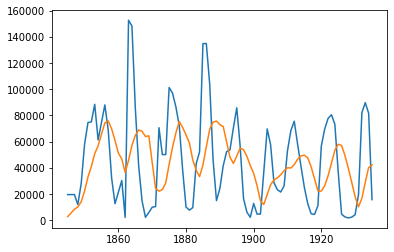

In [9]:
# simple smoothing kernel
t = pelts.Year

n = 7
kernel = np.ones(n)/n

signal = pelts.Hare

alpha = convo(signal, kernel)

plt.plot(t, signal, label = 'Signal')
plt.plot(t, alpha[:len(signal)], label = 'Convolution')

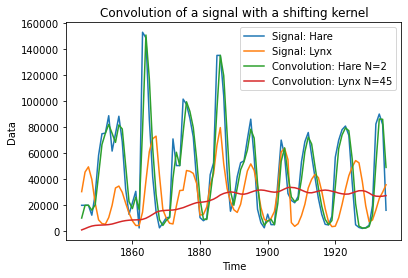

In [10]:
# conv = np.convolve(signal, kernel, 'same') 
n = 2
kernel = np.ones(n)/n

n2 = 45
kernel2 = np.ones(n2)/n2

signal = pelts.Hare
signal2 = pelts.Lynx

t = pelts.Year

beta = np.convolve(signal, kernel)
gamma = np.convolve(signal2, kernel2)

plt.plot(t, signal, label = 'Signal: Hare')
plt.plot(t, signal2, label = 'Signal: Lynx')
plt.plot(t, beta[:len(signal)], label = 'Convolution: Hare N=2')
plt.plot(t, gamma[:len(signal2)], label = 'Convolution: Lynx N=45')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Convolution of a signal with a shifting kernel')
plt.show()

### 2.2 Chicago Covid cases

Below is a data set of the number of confirmed cases of COVID in Chicago (Cook county, to be precise); source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

The variables in the database are `Combined_Key` (location, so it's the same in every row of this file), `date`, and `cumulative` cases. I calculated the number of new cases (`new`) and the number of days since the beginning of the time series (`days`), so please use these two variables for your calculations and plotting.

After plotting the number of new cases, you will see a lot of noise, in part due to weekends and other days in which reporting is delayed. This is why most plots of this type of data, e.g. https://www.nytimes.com/interactive/2021/us/covid-cases.html use some type of smoothing, usually a 7-day running average.

Below, use either your own or the numpy convolution function with a smoothing kernel to calculate a 7-day running average, and then try a larger window size until the plot is visually pleasing without losing any large-scale information, such as the outbreak peaks losing their shape. Plot the data and the different smoothing options in the same window.


In [11]:
chi_covid = pd.read_csv("Chicago_COVID.csv")
chi_covid.head()


,Combined_Key,date,cumulative,new,days
0,"Cook, Illinois, US",1/22/20,0,0,1
1,"Cook, Illinois, US",1/23/20,0,0,2
2,"Cook, Illinois, US",1/24/20,1,1,3
3,"Cook, Illinois, US",1/25/20,1,0,4
4,"Cook, Illinois, US",1/26/20,1,0,5


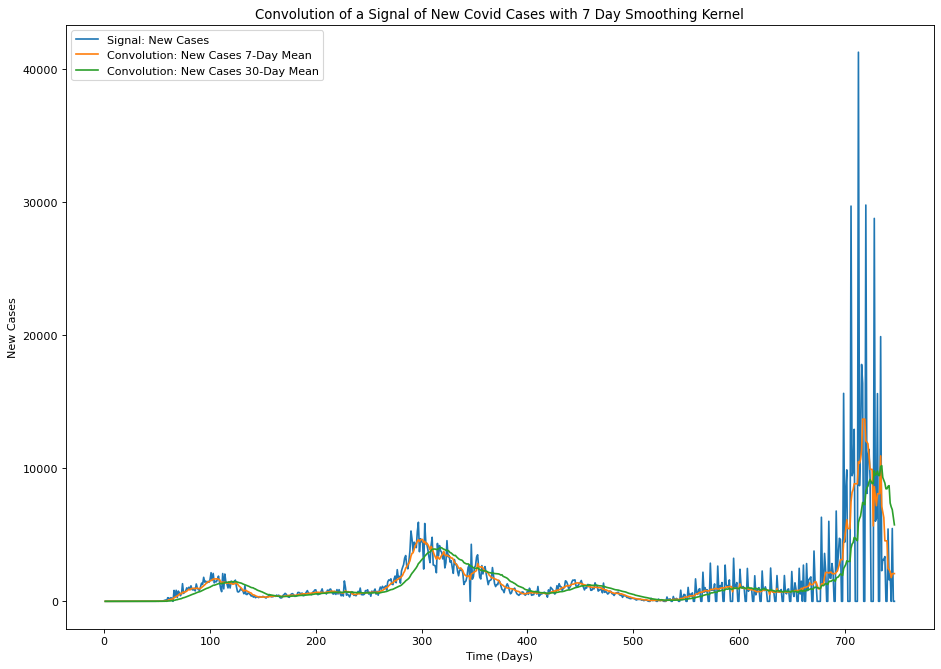

In [12]:
n3 = 7
kernel3 = np.ones(n3)/n3

n4 = 30
kernel4 = np.ones(n4)/n4

signal3 = chi_covid.new

t2 = chi_covid.days

delta = np.convolve(signal3, kernel3)
epsilon = np.convolve(signal3, kernel4)

from matplotlib.pyplot import figure

figure(figsize=(14, 10), dpi=80)

plt.plot(t2, signal3, label = 'Signal: New Cases')
plt.plot(t2, delta[:len(signal3)], label = 'Convolution: New Cases 7-Day Mean')
plt.plot(t2, epsilon[:len(signal3)], label = 'Convolution: New Cases 30-Day Mean')
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('New Cases')
plt.title('Convolution of a Signal of New Covid Cases with 7 Day Smoothing Kernel')
plt.show()

## Part 3: Deconvolution and filtering

The convolution theorem provides a way of recovering a signal that has been distorted by convolution with a kernel. The naive approach of taking the Fourier Transform of both the observed signal and the kernel, dividing them in the Fourier domain, and performing the inverse Fourier transform does not work well in practice for multiple reasons. Instead, there is a way to approximate the original signal that has been distorted by convolution and with additive normal noise on top:
$$
c(t) = s(t)\circ r(t) + n(t)
$$

where S is the original signal, R is the response or kernel, and N is the normally distributed noise. The presence of noise makes recovery of the S(t) impossible exactly, but one can find the least-squares solution, using the Wiener filter. This is an array in the Fourier domain that is calculated like this:

$$
G(f) = \frac{R^*(f)}{|R(f)|^2 + N(f)/C(f)}
$$

This filter G(f) to multiplies the data C(f) in the Fourier domain, and then the inverse Fourier transform calculates the best least-squares reconstruction of the signal S(t). 


### 3.1 Wiener filter implementation

Write a function that performs the Wiener deconvolution, according to this outline:

* Input: two 1-dimensional arrays D (data) and K (kernel), SNR (signal to noise ratio)
* DO:
    + check that both D and K are 1-dimensional arrays and that K is shorter than D, otherwise return error message
    + normalize the kernel (make sure it adds up to 1)
    + DF = calculate FT of D (use `fft`)
    + KF = calculate FT of K (use `fft` with option n = length of D)
    + calculate (use `np.conj`) $$ G =  \frac{KF ^*}{|KF|^2 + 1/SNR} $$
    + multiply DF by G (use `*`)
    + return the real part of the inverse FT of the last array (use `ifft` and `np.real`)

In principle, the signal to noise ratio can be calculated for the entire spectrum, but it may be hard to do in practice. One simple hack that we will use is to set SNR to a constant, for example by estimating the power of the uniform noise (especilly at high frequencies) and the power of the signal at peaks in the frequency spectrum.

The code below generates a periodic signal, convolves it with the smoothing function, and add some normally distributed noise. 

Implement the Wiener filter and test it on this fake data set, using SNR = 1. Plot the true signal (`signal`) and overlay the convolved and noisy data, as well as with the deconvolution using the filter. How well does the deconvolution match the original signal?

In [60]:
def wiener_convo(data, kernel, snr):
    """This computes the Weiner deconvolution of two arrays"""
    
    # Check dimensionality here and length
    if len(data.shape) and len(kernel.shape) > 1:
        raise ValueError('One or both arrays are not one-dimensional') 
    elif len(kernel) > len(data):
        raise ValueError('One or both arrays are not one-dimensional')
        
    #normalization
    normal_kernel = np.sum(kernel)/len(kernel)
#     print(normal_kernel)
    
    # calculate FT of data
    DF = fft(data)
    
    # calculate FT of kernel
    KF = fft(kernel, n=len(data))
    
    # calculate conjugate of KF
    KFconj = np.conj(KF)
    
    # multiplying DF with G
    G = KFconj/(np.abs(KF)**2+(1/snr))
    DFG = DF*G
    
    return np.real(ifft(DFG))

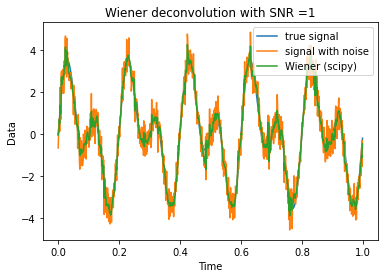

In [61]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t = np.arange(0,Max_time,Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
signal = w1*np.sin(2*np.pi*ff1*t)+ w2*np.sin(2*np.pi*ff2*t) # add two sine waves

# simple smoothing kernel
n = 7
kernel = np.ones(n)/n
conv = np.convolve(signal, kernel, 'same')
w3 = 0.5 # weight of random noise
signal_noise = signal + w3*np.random.normal(0,1,L) # add normal noise

filtered_scipy = wiener(signal_noise, mysize=n)

SNR = 1

plt.plot(t, signal, label = 'true signal')
plt.plot(t, signal_noise, label = 'signal with noise')
plt.plot(t, filtered_scipy, label = 'Wiener (scipy)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title("Wiener deconvolution with SNR ="+ str(SNR))
plt.show()

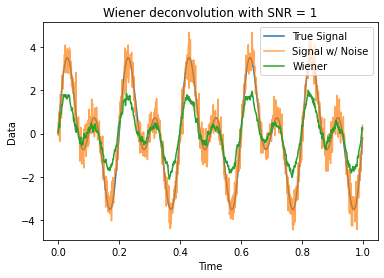

In [64]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t3 = np.arange(0, Max_time, Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
signal4 = w1*np.sin(2*np.pi*ff1*t3)+ w2*np.sin(2*np.pi*ff2*t3) # add two sine waves

n5 = 7
kernel5 = np.ones(n5)/n5
conv = np.convolve(signal4, kernel5, 'same')
w3 = 0.5 # weight of random noise
signal_noise2 = signal4 + w3*np.random.normal(0,1,L) # add normal noise

snr = 1

my_wiener = wiener_convo(signal_noise2, kernel5, snr)

plt.plot(t3, signal4, label = 'True Signal')
plt.plot(t3, signal_noise2, alpha=0.7,  label = 'Signal w/ Noise')
plt.plot(t3, my_wiener, label = 'Wiener')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title("Wiener deconvolution with SNR = " + str(snr))
plt.show()

The Weiner deconvolution fits the behavior of the original signal very accurately. The amplitude of the Weiner convolution, however, does not fit the amplitude of the original signal very well. Compared to the original signal, the amplitude of the Weiner deconvolution is smaller.

### 3.2  Wiener filter tuning
Now let us experiment with different SNR values to see which one does the best job of recovering the signal. To compare them, calculate and report the sum of squared difference between the signal and the noisy data, and then do the same for the deconvoluted signal. Vary the SNR parameter until you find the lowest sum of squared errors, then plot that reconstruction. Change the amount of noise (w3) and report how you need to adjust SNR to obtain the closest reconstruction of the original signal. Compare the result to the quality of the deconvolution by the scipy wiener filter.

RMSD of noisy signal 951.8642342072949
RMSD of scipy Wiener filtered 202.9266628866647


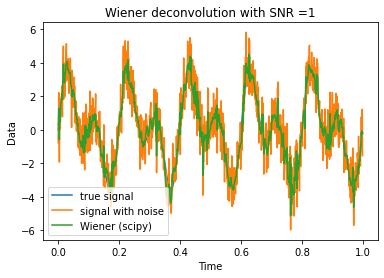

In [67]:
import random
random.seed(2)

L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t = np.arange(0,Max_time,Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
signal = w1*np.sin(2*np.pi*ff1*t)+ w2*np.sin(2*np.pi*ff2*t) # add two sine waves

# simple smoothing kernel
n = 7
kernel = np.ones(n)/n
conv = np.convolve(signal, kernel, 'same')
w3 = 1 # weight of random noise
signal_noise = signal + w3*np.random.normal(0,1,L) # add normal noise


print("RMSD of noisy signal", np.sum((signal_noise - signal)**2)) # root mean sqared distance b/w noisy signal and original 
filtered_scipy = wiener(signal_noise, mysize=n)
print("RMSD of scipy Wiener filtered", np.sum((filtered_scipy - signal)**2)) # root mean sqared distance b/w winer filtered signal and original 

plt.plot(t, signal, label = 'true signal')
plt.plot(t, signal_noise, label = 'signal with noise')
plt.plot(t, filtered_scipy, label = 'Wiener (scipy)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title("Wiener deconvolution with SNR ="+ str(SNR))
plt.show()


RMSD of noisy signal 248.24435841692076
0.14285714285714282
RMSD of implemented Wiener filtered 275.02846335537674


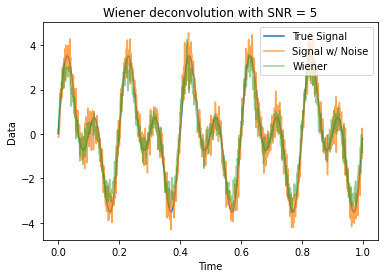

In [55]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t3 = np.arange(0, Max_time, Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
signal4 = w1*np.sin(2*np.pi*ff1*t3)+ w2*np.sin(2*np.pi*ff2*t3) # add two sine waves

n5 = 7
kernel5 = np.ones(n5)/n5
conv = np.convolve(signal4, kernel5, 'same')
w3 = 0.5 # weight of random noise
signal_noise2 = signal4 + w3*np.random.normal(0,1,L) # add normal noise

snr = 5
print("RMSD of noisy signal", np.sum((signal_noise2 - signal4)**2)) # root mean sqared distance b/w noisy signal and original 
my_wiener = wiener_convo(signal_noise2, kernel5, snr)
print("RMSD of implemented Wiener filtered", np.sum((my_wiener - signal4)**2)) # root mean sqared distance b/w winer filtered signal and original 

plt.plot(t3, signal4, label = 'True Signal')
plt.plot(t3, signal_noise2, alpha=0.7,  label = 'Signal w/ Noise')
plt.plot(t3, my_wiener, alpha=0.5, label = 'Wiener')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title("Wiener deconvolution with SNR = " + str(snr))
plt.show()


RMSD of noisy signal 2331.442572652941
RMSD of implemented Wiener filtered 785.2584222522298


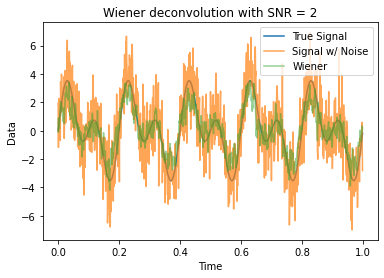

In [83]:
L = 1000 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t3 = np.arange(0, Max_time, Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 5   # frequency 1 of the signal
ff2 = 10  # frequency 2 of the signal
w1 = 2 # weight of frequency 1
w2 = 2 # weight of frequency 2
signal4 = w1*np.sin(2*np.pi*ff1*t3)+ w2*np.sin(2*np.pi*ff2*t3) # add two sine waves

n5 = 7
kernel5 = np.ones(n5)/n5
conv = np.convolve(signal4, kernel5, 'same')
w3 = 1.5 # weight of random noise
signal_noise2 = signal4 + w3*np.random.normal(0,1,L) # add normal noise

snr = 2
print("RMSD of noisy signal", np.sum((signal_noise2 - signal4)**2)) # root mean sqared distance b/w noisy signal and original 
my_wiener = wiener_convo(signal_noise2, kernel5, snr)
print("RMSD of implemented Wiener filtered", np.sum((my_wiener - signal4)**2)) # root mean sqared distance b/w winer filtered signal and original 

plt.plot(t3, signal4, label = 'True Signal')
plt.plot(t3, signal_noise2, alpha=0.7,  label = 'Signal w/ Noise')
plt.plot(t3, my_wiener, alpha=0.5, label = 'Wiener')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title("Wiener deconvolution with SNR = " + str(snr))
plt.show()

When I increase noise within the weight of the signal I have to decrease SNR to be able to fit the Wiener deconvolution to the original signal. The opposite is true when I decrease the noise within the weight of the signal. I have to increase SNR to fit the Weiner deconvolution to the original signal. The quality of the implemented Weiner deconvolution matches accurately with scipy Weiner filter.